# Композиционная теория игр и нейросети: эксперимент

- **Теория**: И.В.Томилов ivan-tomilov3@yandex.ru
- **Реализация**: М.А.Зайцева maria@tail-call.ru

In [84]:
pip install torch torchvision 'numpy<2'

38932.91s - pydevd: Sending message related to process being replaced timed-out after 5 seconds



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Переопределение поведения обратного распространения ошибки

### [Примерная схема того, как переопределить backward][1]

Хочется, чтобы было так:

```python
class LayerWithCustomGrad(nn.Module):
    def __init__(self):
        super(LayerWithCustomGrad, self).__init__()
        self.weights = nn.Parameter(torch.randn(200))

    def forward(self,x):
        return x * self.weights


    def backward(self,grad_of_c): # This gets called during loss.backward()
        # grad_of_c comes from the gradient of b*23
        grad_of_a = some_operation(grad_of_c)

        # perform extra computation
        # and more computation

        self.weights.grad = another_operation(grad_of_a,grad_of_c)
        return grad_of_a # and the grad of parameter "a" will receive this


layer = LayerWithCustomGrad()

a = nn.Parameter(torch.randn(200),requires_grad=True)
b = layer(a)
c = b*23
```

Но нужно так:

```python
class F(torch.autograd.Function):
    """Both forward and backward are static methods."""

    @staticmethod
    def forward(ctx, input, weights):
        """
        In the forward pass we receive a Tensor containing the input and return
        a Tensor containing the output. ctx is a context object that can be used
        to stash information for backward computation. You can cache arbitrary
        objects for use in the backward pass using the ctx.save_for_backward method.
        """
        ctx.save_for_backward(input, weights)
        return input*weights

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the inputs: here input and weights
        """
        input, weights = ctx.saved_tensors
        grad_input = weights.clone()*grad_output
        grad_weights = input.clone()*grad_output
        return grad_input, grad_weights

class LayerWithCustomGrad(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.rand(10))
        self.fn = F.apply

    def forward(self, x):
        return self.fn(x, self.weights)

>>> layer = LayerWithCustomGrad()
>>> x = torch.randn(10, requires_grad=True)
>>> y = layer(x)
tensor([ 0.2023,  0.7176,  0.3577, -1.3573,  1.5185,  0.0632,  0.1210,  0.1566,
         0.0709, -0.4324], grad_fn=<FBackward>)

>>> y.mean().backward()
>>> x.grad # i.e. grad_input in F.backward
tensor([0.0141, 0.0852, 0.0450, 0.0922, 0.0400, 0.0988, 0.0762, 0.0227, 0.0569,
        0.0309])
>>> layer.weights.grad # i.e. grad_weights in F.backward
tensor([-1.4584, -2.1187,  1.5991,  0.9764,  1.8956, -1.0993, -3.7835, -0.4926,
         0.9477, -1.2219])
```

### [Ещё полезная ссылка про переопределение backward с полезным комментарием][2]

Полезный комментарий направляет на [Extending PyTorch][6]. В частности,
в ней есть секции [Extending `torch.autograd`][7], [How to use][8]:

> 1. Subclass `Function` and implement the `forward()`, (optional)
> `setup_context()` and `backward()` methods.
> 2. Call the proper methods on the `ctx` argument.
> 3. Declare whether your function supports [double backward][9].
> 4. Validate whether your gradients are correct using gradcheck.

Кроме того, в **Step 4** сказано:

> It is recommended that you use [`torch.autograd.gradcheck()`][10] to
> check whether your backward function correctly computes gradients of
> the forward by computing the Jacobian matrix using your backward
> function and comparing the value element-wise with the Jacobian
> computed numerically using finite-differencing.

Из документации [gradcheck][11]:

```python
torch.autograd.gradcheck.gradcheck(
     func,
     inputs,
     *,
     eps=1e-06,
     atol=1e-05,
     rtol=0.001,
     raise_exception=True,
     nondet_tol=0.0,
     check_undefined_grad=True,
     check_grad_dtypes=False,
     check_batched_grad=False,
     check_batched_forward_grad=False,
     check_forward_ad=False,
     check_backward_ad=True,
     fast_mode=False,
     masked=None
)
```

***NB***: что-то про *Wirtinger and Conjugate Wirtinger derivatives*,
очень сложно…

### [Определение слоя nn.Linear в pytorch][3]

Модуль `Linear` применяет аффинную линейную трансформацию ко входным
данным:

$$
y = xA^T + b,
$$

где:
- $x$ — `input`
- $y$ – `forward()`
- $A$ — `weight`
- $b$ — `bias`

Параметры:
- `in_features` — размер входа
- `out_features` — размер выхода
- `bias` — если `True`, модель не будет учить смещение

Веса и смещения инициализируются равномерным [распределением Кайминга][12].

Определение `forward()`:

```python
def forward(self, input: Tensor) -> Tensor:
    return F.linear(input, self.weight, self.bias)
```

[Документация][15] `backward(ctx, *grad_outputs)`:

> It must accept a context `ctx` as the first argument, followed by as
> many outputs as the `forward()` returned (None will be passed in for
> non tensor outputs of the forward function), and it should return as
> many tensors, as there were inputs to `forward()`. Each argument is
> the gradient w.r.t the given output, and each returned value should
> be the gradient w.r.t. the corresponding input. If an input is not
> a Tensor or is a Tensor not requiring grads, you can just pass `None`
> as a gradient for that input.

### [torch.diag() для диагональной матрицы, на которую надо будет умножать входящий градиент][4]

```python
torch.diag(
     # Вектор или матрица
     input,
     # 0 – главная диагональ, > 0 – над главной, < 0 – под главной
     diagonal=0,
     *,
     # Тензор, в который выводится результат
     out=None
) → Tensor
```

Если `input` вектор — возвращает квадратный двухмерный тензор с
элементами `input` в диагонали.

Если `input` матрица – возвращает одномерный тензор с диагональными
элементами из `input`.

### [Диагональ нужно будет генерировать на базе torch.bernoulli][5]

```python
torch.bernoulli(
     # Тензор с вероятностями случайно выбрать 0 или 1.
     # Все значения должны быть в диапазоне 0 <= input[i] <= 1
     input,
     *,
     # ПГСЧ
     generator=None,
     # Тензор, в который выводится результат
     out=None
) → Tensor
```

Значения в выходном тензоре генерируются по [распределению Бернулли][13]:

$$
\mathrm{out}_i ∼ \mathrm{Bernoulli}(p = \mathrm{input}_i)
$$

В возвращаемом тензоре такой же `.shape`, как у `input`.

### Что ещё понадобится?

[torch.ones_like][14]:

```python
torch.ones_like(
     input,
     *,
     dtype=None,
     layout=None,
     device=None,
     requires_grad=False,
     memory_format=torch.preserve_format
) → Tensor
```

Она эквивалентна вызову:
```python
torch.ones(input.size(), dtype=input.dtype, layout=input.layout, device=input.device)
```

[1]: https://stackoverflow.com/questions/69500995/is-there-a-way-to-overide-the-backward-operation-on-nn-module
     "python - Is there a way to overide the backward operation on nn.Module - Stack Overflow"
[2]: https://discuss.pytorch.org/t/how-to-overwrite-a-backwards-pass/65845/4
     "How to overwrite a backwards pass - PyTorch Forums"
[3]: https://pytorch.org/docs/stable/_modules/torch/nn/modules/linear.html#Linear
     "torch.nn.modules.linear — PyTorch 2.4 documentation"
[4]: https://pytorch.org/docs/stable/generated/torch.diag.html
     "torch.diag — PyTorch 2.4 documentation"
[5]: https://pytorch.org/docs/stable/generated/torch.bernoulli.html
     "torch.bernoulli — PyTorch 2.4 documentation"
[6]: https://pytorch.org/docs/main/notes/extending.html
     "Extending PyTorch — PyTorch main documentation"
[7]: https://pytorch.org/docs/main/notes/extending.html#extending-torch-autograd
     "Extending PyTorch — PyTorch main documentation"
[8]: https://pytorch.org/docs/main/notes/extending.html#how-to-use
     "Extending PyTorch — PyTorch main documentation"
[9]: https://pytorch.org/tutorials/intermediate/custom_function_double_backward_tutorial.html
     "Double Backward with Custom Functions — PyTorch Tutorials 2.4.0+cu121 documentation"
[10]: https://pytorch.org/docs/main/autograd.html#module-torch.autograd.gradcheck
     "Automatic differentiation package - torch.autograd — PyTorch main documentation"
[11]: https://pytorch.org/docs/main/generated/torch.autograd.gradcheck.gradcheck.html#torch.autograd.gradcheck.gradcheck
     "torch.autograd.gradcheck.gradcheck — PyTorch main documentation"
[12]: https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_uniform_
     "torch.nn.init — PyTorch 2.4 documentation"
[13]: https://en.wikipedia.org/wiki/Bernoulli_distribution
     "Bernoulli distribution - Wikipedia"
[14]: https://pytorch.org/docs/stable/generated/torch.ones_like.html
     "torch.ones_like — PyTorch 2.4 documentation"
[15]: https://pytorch.org/docs/main/generated/torch.autograd.Function.backward.html#torch.autograd.Function.backward
     "https://pytorch.org/docs/main/generated/torch.autograd.Function.backward.html#torch.autograd.Function.backward"

## Данные

In [2]:
from dataclasses import dataclass

import torch

from torchvision import datasets, transforms

@dataclass
class Dataset:
    train_dataset: datasets.MNIST
    test_dataset: datasets.MNIST
    train_loader: torch.utils.data.DataLoader
    test_loader: torch.utils.data.DataLoader

def make_dataset(root: str, batch_size: int) -> Dataset:
    transform = transforms.Compose([
        transforms.ToTensor(),
        # https://discuss.pytorch.org/t/normalization-in-the-mnist-example/457
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_dataset = datasets.MNIST(
        root=root,
        train=True,
        download=True,
        transform=transform
    )

    test_dataset = datasets.MNIST(
        root=root,
        train=False,
        download=True,
        transform=transform
    )

    return Dataset(
        train_dataset=train_dataset,
        test_dataset=test_dataset,
        train_loader=torch.utils.data.DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True
        ),
        test_loader=torch.utils.data.DataLoader(
            test_dataset,
            batch_size=batch_size,
            shuffle=False
        )
    )

dataset = make_dataset(root='./data', batch_size=64)


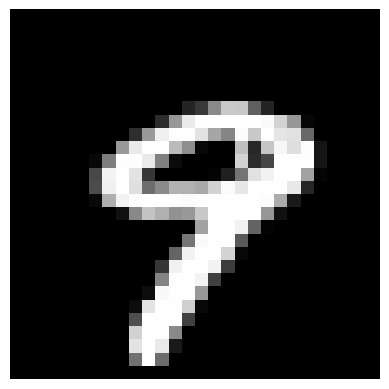

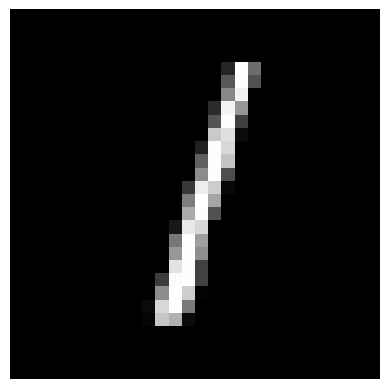

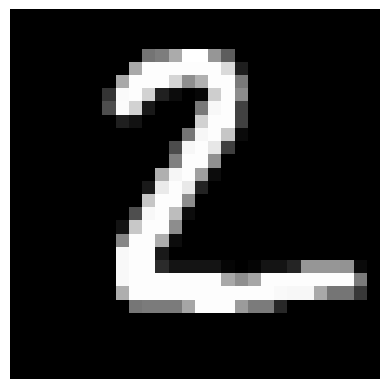

In [3]:
import matplotlib.pyplot as plt

def draw(tensor: torch.Tensor):
    plt.imshow(tensor, cmap='gray')
    plt.axis('off')
    plt.show()

draw(dataset.test_dataset.data[9])
draw(dataset.test_dataset.data[2])
draw(dataset.test_dataset.data[1])

## Модели

In [10]:
import torch.nn as nn
import torch.nn.functional as F

class CustomBackwardFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, weight, bias) -> torch.Tensor:
        ctx.save_for_backward(input, weight, bias)
        # return input * weights
        # return input @ weights.t()
        return F.linear(input, weight, bias)

    @staticmethod
    def backward(ctx, grad_output):
        """
        Gradient formula.

        It will be given as many `Tensor` arguments as there were
        outputs, with each of them representing gradient w.r.t. that
        output. It is important NEVER to modify these in-place. It
        should return as many tensors as there were inputs, with each
        of them containing the gradient w.r.t. its corresponding
        input. If your inputs didn’t require gradient (needs_input_grad
        is a tuple of booleans indicating whether each input needs
        gradient computation), or were non-Tensor objects, you can
        return `None`. Also, if you have optional arguments to
        """
        input, weights, bias = ctx.saved_tensors

        diag_matrix = torch.bernoulli(torch.ones_like(weights) * 0.5)
        diag_matrix = torch.diag(diag_matrix)

        grad_output = grad_output @ diag_matrix

        grad_input = weights * grad_output
        grad_weights = input * grad_output

        if bias is not None and ctx.needs_input_grad[2]:
            grad_bias = grad_output.sum(0)
        else:
            grad_bias = None

        return grad_input, grad_weights, grad_bias

class DigitRecognizer(nn.Module):
    def __init__(self):
        super(DigitRecognizer, self).__init__()

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(28 * 28, 32 * 32)
        self.fc2 = nn.Linear(32 * 32, 32 * 32)
        self.fc3 = nn.Linear(32 * 32, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

class DigitRecognizerCustomBackward(nn.Module):
    def __init__(self):
        super(DigitRecognizerCustomBackward, self).__init__()

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(28 * 28, 32 * 32)
        self.fc2 = nn.Linear(32 * 32, 32 * 32)
        self.fc3 = nn.Linear(32 * 32, 10)

        self.custom_backward = CustomBackwardFunction.apply

    def forward(self, x):
        x = self.flatten(x)
        x = self.custom_backward(x, self.fc1.weight, self.fc1.bias)
        x = F.relu(x)
        x = self.custom_backward(x, self.fc2.weight, self.fc2.bias)
        x = F.relu(x)
        x = self.fc3(x)
        return x

## Обучение

In [11]:
import torch.optim as optim

MeanStd = tuple[float, float]

def dabs_mean_std(
    tensor1: torch.Tensor,
    tensor2: torch.Tensor
) -> MeanStd:
    dabs: torch.Tensor = torch.abs(tensor2 - tensor1)

    mean = torch.mean(dabs)
    std = torch.std(dabs)

    return (mean.item(), std.item())


def train(model: DigitRecognizer, loader, epochs, criterion, optimizer):
    # Наблюдаемые величины
    running_losses: list[float] = []
    fc1_dabs_mean: list[float] = []
    fc1_dabs_std: list[float] = []
    fc2_dabs_mean: list[float] = []
    fc2_dabs_std: list[float] = []
    fc3_dabs_mean: list[float] = []
    fc3_dabs_std: list[float] = []

    for epoch in range(epochs):
        running_loss = 0.0

        model.train()

        for i, (inputs, labels) in enumerate(loader):
            optimizer.zero_grad()

            outputs = model(inputs)

            loss = criterion(outputs, labels)
            loss.backward()

            fc1_weight = model.fc1.weight.clone()
            fc2_weight = model.fc2.weight.clone()
            fc3_weight = model.fc3.weight.clone()

            optimizer.step()

            running_loss += loss.item()

            if i % 100 == 99:
                (mean1, std1) = (dabs_mean_std(fc1_weight, model.fc1.weight))
                fc1_dabs_mean.append(mean1)
                fc1_dabs_std.append(std1)

                (mean2, std2) = (dabs_mean_std(fc2_weight, model.fc2.weight))
                fc2_dabs_mean.append(mean2)
                fc2_dabs_std.append(std2)

                (mean3, std3) = (dabs_mean_std(fc3_weight, model.fc3.weight))
                fc3_dabs_mean.append(mean3)
                fc3_dabs_std.append(std3)

                print(f'E{epoch + 1}/{epochs} S{i + 1}/{len(loader)} Loss={running_loss / 100:.4f}')
                running_losses.append(running_loss)
                running_loss = 0.0

    X = range(len(fc1_dabs_mean))

    plt.figure(figsize=(10, 6))

    def plot_mean_std(label, color, series_mean, series_std):
        plt.plot(X, series_mean, label=label, color=color)

        plt.fill_between(
            X,
            [m - s for m, s in zip(series_mean, series_std)],
            [m + s for m, s in zip(series_mean, series_std)],
            color=color,
            alpha=0.2
        )

    plot_mean_std('FC1 Mean', 'blue', fc1_dabs_mean, fc1_dabs_std)
    plot_mean_std('FC2 Mean', 'green', fc2_dabs_mean, fc2_dabs_std)
    plot_mean_std('FC3 Mean', 'red', fc3_dabs_mean, fc3_dabs_std)

    plt.plot(X, running_losses, label='Running loss', color='orange')

    plt.xlabel('Iteration')
    plt.ylabel('Value')
    plt.title('Mean Values with Standard Deviation for FC Layers')
    plt.legend()

    plt.show()


# model1 = DigitRecognizer()

# train(
#     model=model1,
#     loader=dataset.train_loader,
#     epochs=5,
#     criterion=nn.CrossEntropyLoss(),
#     optimizer=optim.Adam(
#         model1.parameters(),
#         lr=0.001
#     )
# )

# torch.save(model1.state_dict(), 'digit_recognizer1.pth')

model2 = DigitRecognizerCustomBackward()

train(
    model=model2,
    loader=dataset.train_loader,
    epochs=5,
    criterion=nn.CrossEntropyLoss(),
    optimizer=optim.Adam(
        model2.parameters(),
        lr=0.001
    )
)

torch.save(model2.state_dict(), 'digit_recognizer2.pth')



RuntimeError: The size of tensor a (1024) must match the size of tensor b (64) at non-singleton dimension 1

## Валидация

In [40]:
import torch
model1 = DigitRecognizer()
model1.load_state_dict(torch.load('digit_recognizer.pth'))

model1.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in dataset.test_loader:
        outputs = model1(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy: {correct / total * 100}%')

Accuracy: 61.59%


## Предсказания

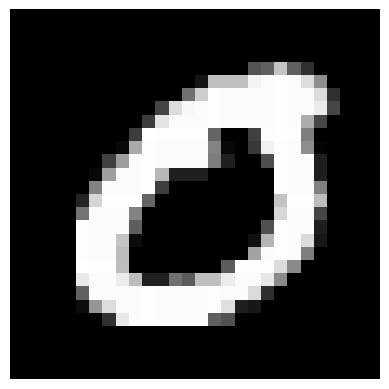

tensor([ 4.9585, -1.5439,  0.0612, -0.2481, -1.5726,  0.3865, -0.2381, -0.9189,
        -0.7883, -0.5468], grad_fn=<SelectBackward0>)


(0, tensor([0]))

In [41]:
import torch
model1 = DigitRecognizer()
model1.load_state_dict(torch.load('digit_recognizer.pth'))

idx = 997 

draw(dataset.test_dataset.data[idx])

(X, y) = dataset.test_dataset[idx]

outputs = model1(X)
_, predicted = torch.max(outputs.data, 1)
print(outputs[0])

(y, predicted)
